In [7]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import pdb 
import time
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix

import sys
import os 

seed = 42
np.random.seed(seed)

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(seed)
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(seed)
    
# Helper methods for loading CORA Graph
from utils import load_data2,load_data3,accuracy

cuda available


### Setup for Cora Dataset

In [8]:
# Load data (GCN)
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, labels = load_data3('cora')
adj = adj.toarray().astype(float)
adj += np.eye(adj.shape[0])
idx_train = np.argwhere(train_mask).reshape(-1)
idx_val = np.argwhere(val_mask).reshape(-1)
idx_test = np.argwhere(test_mask).reshape(-1)
labels = torch.LongTensor(np.where(labels)[1])

In [9]:
new_edges = []
for v1 in idx_train:
    for v2 in idx_train:
        if v1 != v2 and adj[v1, v2] != 1: # and labels[v1] == labels[v2]:
            new_edges.append((v1,v2))
new_edges = np.array(new_edges)

In [10]:
def dropin(new_edges, rate, dim=2708):
    np.random.shuffle(new_edges)
    v = new_edges.shape[0]
    E_start = np.zeros((v, dim))
    E_end = np.zeros((v, dim))
    for i in range(0, int(v*rate), 2):
        v1, v2 = new_edges[i]
        E_start[i,v1] = E_end[i,v2] = E_start[i+1,v1] = E_end[i+1,v2] = 1
    E_start = Variable(torch.from_numpy(E_start[:i+2,:]).float())
    E_end = Variable(torch.from_numpy(E_end[:i+2,:]).float())
    return E_start.cuda(), E_end.cuda()

In [11]:
# Load data (pyGCN)
# adj, features, labels, idx_train, idx_val, idx_test = load_data2()

# adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
# adj = adj.toarray()
# adj += np.eye(adj.shape[0])

cora_Estart = np.zeros((20000, 2708))
cora_Eend = np.zeros((20000, 2708))
cora_Eidentity = [] # idx of identity edges

# converting adjacency matrix to edge-to-start, edge-to-end vertex matrix
count = 0
for i in range(adj.shape[0]):
    for j in range(adj.shape[1]):
        if adj[i,j] == 1:
            cora_Estart[count,i] = 1
            cora_Eend[count,j] = 1
            if i == j:
                cora_Eidentity.append(count)
            count += 1
cora_Estart = cora_Estart[:count]
cora_Eend = cora_Eend[:count]

def get_cora_dataset():
    x = Variable(features, requires_grad=False)
    y = Variable(labels)
    E_start = Variable(torch.from_numpy(cora_Estart).float())
    E_end = Variable(torch.from_numpy(cora_Eend).float())
    
    return x.cuda(), y.cuda(), E_start.cuda(), E_end.cuda(), cora_Eidentity, new_edges

In [13]:
class OurConvNetcell(nn.Module):
    def __init__(self, dim_in, dim_out, dropout_fc=0, dropout_edge=0):
        super(OurConvNetcell, self).__init__()
    
        # conv1
        self.Ui1 = nn.Linear(dim_in, dim_out, bias=False) 
        self.Vi1 = nn.Linear(dim_in, dim_out, bias=False) 
        self.Vj1 = nn.Linear(dim_in, dim_out, bias=False)  
        self.bu1 = torch.nn.Parameter( torch.FloatTensor(dim_out), requires_grad=True )
        self.bv1 = torch.nn.Parameter( torch.FloatTensor(dim_out), requires_grad=True )
        
        self.dropout_fc = dropout_fc
        self.dropout_edge = dropout_edge
        
        # conv2
        self.Ui2 = nn.Linear(dim_out, dim_out, bias=False) 
        self.Vi2 = nn.Linear(dim_out, dim_out, bias=False) 
        self.Vj2 = nn.Linear(dim_out, dim_out, bias=False)  
        self.bu2 = torch.nn.Parameter( torch.FloatTensor(dim_out), requires_grad=True )
        self.bv2 = torch.nn.Parameter( torch.FloatTensor(dim_out), requires_grad=True )
        
        # bn1, bn2
        self.bn1 = torch.nn.BatchNorm1d(dim_out)
        self.bn2 = torch.nn.BatchNorm1d(dim_out)
        
        # resnet
        self.R = nn.Linear(dim_in, dim_out, bias=False) 
        
        # init
        self.init_weights_OurConvNetcell(dim_in, dim_out, 1)
        
         
    def init_weights_OurConvNetcell(self, dim_in, dim_out, gain):   
        # conv1
        scale = gain* np.sqrt( 2.0/ dim_in )
        self.Ui1.weight.data.uniform_(-scale, scale) 
        self.Vi1.weight.data.uniform_(-scale, scale) 
        self.Vj1.weight.data.uniform_(-scale, scale) 
        self.bu1.data.fill_(0)
        self.bv1.data.fill_(0)
        
        # conv2
        scale = gain* np.sqrt( 2.0/ dim_out )
        self.Ui2.weight.data.uniform_(-scale, scale) 
        self.Vi2.weight.data.uniform_(-scale, scale) 
        self.Vj2.weight.data.uniform_(-scale, scale) 
        self.bu2.data.fill_(0)
        self.bv2.data.fill_(0)
        
        # RN
        scale = gain* np.sqrt( 2.0/ dim_in )
        self.R.weight.data.uniform_(-scale, scale)  
        
        
    def forward(self, x, E_start, E_end):
        x = F.dropout(x, self.dropout_fc, training=self.training)
        xin = x
        
        # edge norm
        norm = torch.sum(E_end.t(), 1).reshape(-1,1)
#         norm = torch.max(norm, torch.ones(norm.shape).cuda())

        # conv1
        Uix = self.Ui1(x)  #  V x H_out
        Vix = self.Vi1(x)  #  V x H_out
        Vjx = self.Vj1(x)  #  V x H_out
        x1 = torch.mm(E_end,Vix) + torch.mm(E_start,Vjx) + self.bv1  # E x H_out
        x1 = torch.sigmoid(x1)
        x1 = F.dropout(x1, self.dropout_fc, training=self.training)

        x2 = torch.mm(E_start, Uix)  #  E x H_out
        x = torch.mm(E_end.t(), x1*x2) + self.bu1 #  V x H_out
        
        x = torch.div(x, norm)# norm
        x = self.bn1(x) # bn1
        x = torch.nn.LeakyReLU(0.2)(x) # relu1
        
        # conv2
        Uix = self.Ui2(x)  #  V x H_out
        Vix = self.Vi2(x)  #  V x H_out
        Vjx = self.Vj2(x)  #  V x H_out
        x1 = torch.mm(E_end,Vix) + torch.mm(E_start,Vjx) + self.bv2  # E x H_out
        x1 = torch.sigmoid(x1)
        x1 = F.dropout(x1, self.dropout_fc, training=self.training)
        
        x2 = torch.mm(E_start, Uix)  #  V x H_out        
        x = torch.mm(E_end.t(), x1*x2) + self.bu2 #  V x H_out
        
        x = torch.div(x, norm) # normalization
        
        x = self.bn2(x) # bn2
        x = x + self.R(xin) # addition
        x = torch.nn.LeakyReLU(0.2)(x) # relu2
        
        return x
        
class Graph_OurConvNet(nn.Module):
    def __init__(self, net_parameters, cora=False):
        super(Graph_OurConvNet, self).__init__()
        
        # parameters
        Voc = net_parameters['Voc']
        D = net_parameters['D']
        nb_clusters_target = net_parameters['nb_clusters_target']
        H = net_parameters['H']
        L = net_parameters['L']
        self.cora = cora
        self.dropout_fc = net_parameters['Dropout_fc']
        self.dropout_edge = net_parameters['Dropout_edge']
        self.drop_in = net_parameters['Dropout_in']
        
        # vector of hidden dimensions
        net_layers = []
        for layer in range(L):
            net_layers.append(H)
        
        # CL cells
        # NOTE: Each graph convnet cell uses *TWO* convolutional operations
        net_layers_extended = [net_parameters['features']] + net_layers 
        
        L = len(net_layers)
        list_of_gnn_cells = [] # list of NN cells
        for layer in range(L//2):
            Hin, Hout = net_layers_extended[2*layer], net_layers_extended[2*layer+2]
            list_of_gnn_cells.append(OurConvNetcell(Hin,Hout, self.dropout_fc, self.dropout_edge))
        
        # register the cells for pytorch
        self.gnn_cells = nn.ModuleList(list_of_gnn_cells)
            
        # fc
        Hfinal = net_layers_extended[-1]
        self.fc = nn.Linear(Hfinal,nb_clusters_target) 
        
        # init
        self.init_weights_Graph_OurConvNet(Voc,D,Hfinal,nb_clusters_target,1)
        
        # print
#         print('\nnb of hidden layers=',L)
#         print('dim of layers (w/ embed dim)=',net_layers_extended)      
#         print('\n')
        
        # class variables
        self.D = D
        self.L = L
        self.net_layers_extended = net_layers_extended      
        
        
    def init_weights_Graph_OurConvNet(self, Fin_enc, Fout_enc, Fin_fc, Fout_fc, gain):
        scale = gain* np.sqrt(2.0/ (Fin_fc+Fout_fc))
        self.fc.weight.data.uniform_(-scale, scale)  
        self.fc.bias.data.fill_(0)  
        
    def forward(self, x, E_start, E_end, E_identity, E_dropin):
        if self.training:
            # Edge Start+End Dropout for all layers
            num_edges = E_start.shape[0]
            dropout_idx = np.array([i for i in range(num_edges) if i not in E_identity])
            np.random.shuffle(dropout_idx)
            E_start = E_start.clone()
            E_start[dropout_idx[:int(num_edges*self.dropout_edge)]] = 0
            E_end = E_end.clone()
            E_end[dropout_idx[:int(num_edges*self.dropout_edge)]] = 0
            
            # Dropin
            D_start, D_end = dropin(E_dropin, self.drop_in)
            E_start = torch.cat((E_start, D_start), 0)
            E_end = torch.cat((E_end, D_end), 0)
            
        # convnet cells  
        for layer in range(self.L//2):
            gnn_layer = self.gnn_cells[layer]            
            x = gnn_layer(x,E_start,E_end) # V x H
            
        x = F.dropout(x, self.dropout_fc, training=self.training) #FC Dropout
        x = self.fc(x) # FC
        return x
    
    def plot(self, x, E_start, E_end, E_identity, E_dropin):
        gnn_layer = self.gnn_cells[0]            
        x = gnn_layer(x,E_start,E_end) # V x H
        return x
    
    def loss(self, y, y_target, weight):
        loss = nn.CrossEntropyLoss()(y,y_target)
        return loss
       
    def update(self, lr, l2):
        update = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        return update
    
    def update_learning_rate(self, optimizer, lr):
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        return optimizer
    
    def nb_param(self):
        return self.nb_param

In [14]:
def calculate_avg_accuracy(nb_classes, labels, pred_y):
    S = labels.data.cpu().numpy()
    C = np.argmax(torch.nn.Softmax(dim=1)(pred_y).data.cpu().numpy() , axis=1)
    return np.sum(S==C)/S.shape[0]

def update_lr(net, optimizer, average_loss, average_loss_old, lr, decay_rate, early_stopping, verbose):
    # Update LR if > early_stopping and avg val loss is higher
    if average_loss > average_loss_old and lr > early_stopping:
        lr /= decay_rate
        if verbose:
            print('Updating LR to %.7f' % lr)
    return net.update_learning_rate(optimizer, lr), lr

def print_results(iteration, batch_iters, avg_train_acc, running_train_loss, val_accuracy, lr, t_start):
    print('\niteration= %d, train loss(%diter)= %.3f, lr= %.7f, time(%diter)= %.2f' % 
          (iteration, batch_iters, running_train_loss/batch_iters, lr, 
           batch_iters, time.time() - t_start))
    print('val accuracy= %.3f' % (100* val_accuracy))
    print('train accuracy= %.3f' % (100* avg_train_acc))


In [ ]:
def train(net, lr, l2, batch_iters, early_stopping, verbose=False):
    ### optimization parameters
    nb_classes = 7 
    max_iters = 1000
    decay_rate = 1.25
    SAVE_PATH = 'model_state'

    # Optimizer
    optimizer = net.update(lr, l2) 
    t_start = time.time()
    t_start_total = time.time()
    average_loss_old = torch.tensor(1e4).cuda()
    best = running_train_acc = running_train_loss = running_val_loss = 0.0
    tab_results = []
    
    features_x, train_y, E_start, E_end, E_identity, E_dropin = get_cora_dataset()

    for iteration in range(1, max_iters):  # loop over the dataset multiple times
        # forward, loss
        net.train()
        pred_y = net.forward(features_x, E_start, E_end, E_identity, E_dropin)
        loss = net.loss(pred_y[idx_train], train_y[idx_train], None) 
        train_acc = calculate_avg_accuracy(nb_classes, train_y[idx_train], pred_y[idx_train]) # training acc
        running_train_acc += train_acc    
        running_train_loss += loss.item()

        # backward, update
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # validation eval
        net.eval()
        y_eval = net.forward(features_x, E_start, E_end, E_identity, E_dropin)
        val_loss = net.loss(y_eval[idx_val], train_y[idx_val], None) 
        running_val_loss += val_loss.item()

        # learning rate, print results
        if not iteration%batch_iters:
            val_accuracy = calculate_avg_accuracy(nb_classes, train_y[idx_val], y_eval[idx_val])
            average_val_loss = running_val_loss/ batch_iters
            avg_train_acc = running_train_acc/ batch_iters

            # update learning rate 
            if val_accuracy < avg_train_acc and avg_train_acc > 0.8:
                optimizer, lr = update_lr(net, optimizer, average_val_loss, average_loss_old, 
                                          lr, decay_rate, early_stopping, verbose)

            # save intermediate results
            if val_accuracy > best:
                torch.save(net.state_dict(), SAVE_PATH)
                best = val_accuracy
            tab_results.append([iteration,average_val_loss,100* val_accuracy, time.time()-t_start_total])

            if verbose:
                print_results(iteration, batch_iters, avg_train_acc, running_train_loss, val_accuracy, lr, t_start)
            if lr < torch.tensor(early_stopping).cuda() and avg_train_acc - val_accuracy > 0.05:
                print("Early Stopping at %d. Highest Val: %.3f " % (iteration, max([tab_results[i][2] for i in range(len(tab_results))])))
                return max([tab_results[i][2] for i in range(len(tab_results))])
                break

            # reset counters
            t_start = time.time()
            running_train_acc = running_train_loss = running_val_loss = 0.0
            average_loss_old = average_val_loss
    return max([tab_results[i][2] for i in range(len(tab_results))])

In [15]:
features_x, _, _, _, _, _ = get_cora_dataset()

CORA = 1
net_parameters = {}
net_parameters['features'] = features_x.shape[1]
net_parameters['Voc'] = 7+1 
net_parameters['nb_clusters_target'] = 7
net_parameters['D'] = net_parameters['H'] = 50

### Train

In [16]:
net_parameters['L'] = 6
net_parameters['Dropout_fc'] = 0.5
net_parameters['Dropout_edge'] = 0.5
net_parameters['Dropout_in'] = 0.0075
nb_classes = 7
lr = 0.001
l2 = 0.005
batch_iters = 1
early_stopping = 50e-6
SAVE_PATH = 'model_state'
test_acc = np.zeros((10,1))


for i in range(1):
    net = Graph_OurConvNet(net_parameters, CORA)
    net.cuda()
    
    train(net, lr, l2, batch_iters, early_stopping, verbose=False)
    
    # Eval
    net.load_state_dict(torch.load(SAVE_PATH))
    net.eval()
    features_x, labels, E_start, E_end, V, E_dropin = get_cora_dataset()
    y_eval = net.forward(features_x, E_start, E_end, cora_Eidentity, E_dropin)

    loss = net.loss(y_eval[idx_test], labels[idx_test], None) 
    accuracy = calculate_avg_accuracy(nb_classes, labels[idx_test], y_eval[idx_test])
    print('\nloss(100 pre-saved data)= %.3f, accuracy(100 pre-saved data)= %.3f' % (loss.item(), 100* accuracy))
    test_acc[i] += accuracy

# print("Avg test acc", np.mean(test_acc))

NameError: name 'train' is not defined

In [17]:
net = Graph_OurConvNet(net_parameters, CORA)
net.cuda()
net.load_state_dict(torch.load(SAVE_PATH))
net.eval()
features_x, labels, E_start, E_end, V, E_dropin = get_cora_dataset()
embed = net.forward(features_x, E_start, E_end, cora_Eidentity, E_dropin)

In [130]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

n_sne = 7000
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=70, n_iter=300)
tsne_results = tsne.fit_transform(embed.detach().cpu().numpy())

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 2708
[t-SNE] Computed conditional probabilities for sample 2000 / 2708
[t-SNE] Computed conditional probabilities for sample 2708 / 2708
[t-SNE] Mean sigma: 0.419777
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.734491
[t-SNE] Error after 125 iterations: 0.734491


In [131]:
start = np.argmax(E_start.cpu().numpy(), 1)
end = np.argmax(E_end.cpu().numpy(), 1)
lines = []
seen = set()
for each in range(len(start)):
    i, j = start[each], end[each]
    if (i,j) in seen or (j,i) in seen:
        continue
    x = (tsne_results[i], tsne_results[j])
    lines.append(x)
    seen.add((i,j))
colors = labels.cpu().numpy()

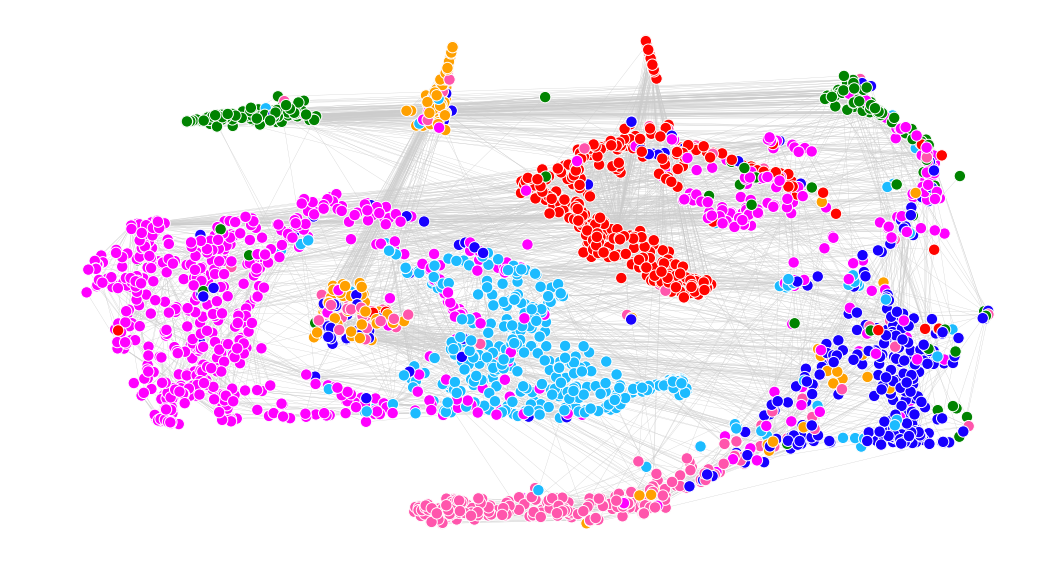

In [132]:
colors = []
cmap = ['#1700FF','#008300','#FF0400','#FF00FF','#1CBBFF', '#FF55AC','#FFA000']
for label in list(labels.cpu().numpy()):
    colors.append(cmap[label])
    
lc = LineCollection(lines, color='#CCCCCC',linewidth=0.3,zorder=-1)

fig = plt.figure(figsize=(18,10))

ax1 = fig.add_subplot(1, 1, 1)
ax1.add_collection(lc)
ax1.autoscale()

ax1.scatter(tsne_results[:,0], tsne_results[:,1], s=130, c=colors, edgecolors="white")
plt.axis('off')
plt.show()

In [ ]:
# plot tsne with class from labels